## Notebook purpose

This notebook produces figures in the methods section which are focussed on parity scoring evaluation.

In [1]:
import pandas as pd
import pickle
import rdkit.Chem as Chem
from rdkit.Chem import BRICS,Recap, rdFMCS
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize

from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import AllChem, MACCSkeys, PandasTools, rdFingerprintGenerator
from rdkit import Chem
from rdkit import DataStructs 

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

RDLogger.DisableLog('rdApp.*')

import math
import numpy as np

from pdbeccdutils.core.models import ParityResult
from pdbeccdutils.computations.parity_method import compare_molecules
from pdbeccdutils.helpers.mol_tools import fix_molecule

import random

import matplotlib.pyplot as plt
import seaborn as sns
#!pip install scikit-learn
from sklearn.metrics import roc_curve, roc_auc_score, auc
import os
#mkae a sanitisation function

def pdbe_sanitise_smiles(smiles, return_mol = False, return_sanitisation = False):
    """
    Sanitises a smiles string using pdbeccdutils fix_molecule functions and
    returns a canonical smiles string or RDKit molecule object. Requires that
    smiles string can be loaded into an RDKit molecule object - returns none if
    this is not possible.
    """
    try:
        mol = Chem.MolFromSmiles(Chem.CanonSmiles(smiles))
    except:
        if return_sanitisation:
            return None, None
        else:
            return None
    
    sanitisation = fix_molecule(mol)
    if sanitisation:
        if return_mol:
            if return_sanitisation:
                return mol, sanitisation
            else:
                return mol
        else:
            sanitised_smiles = Chem.CanonSmiles(Chem.MolToSmiles(mol))
            if return_sanitisation:
                return sanitised_smiles, sanitisation
            else:
                return sanitised_smiles
    else:
        sanitised_smiles = None
        if return_sanitisation:
            return sanitised_smiles, sanitisation
        else:
            return sanitised_smiles
        
def score_random_pairs(row):
    try:
        mol1, mol1_sanitisation = pdbe_sanitise_smiles(row.descriptor, return_mol = True, return_sanitisation = True)
        mol2, mol2_sanitisation = pdbe_sanitise_smiles(row.canonical_smiles, return_mol = True, return_sanitisation = True)
    except:
        mol1_sanitisation = False
        mol2_sanitisation = False
    if mol1_sanitisation and mol2_sanitisation:
        parity = compare_molecules(mol1, mol2, thresh = 0.1)
        parity_score = parity.similarity_score
        parity_match = parity.mapping
    else:
        print("sanitisation failed")
        parity_score = 0
        parity_match = None
    return parity_score

def get_cognate_score(row, cognate_ligands_df, parity_df):
    cognate_ligand_smiles = cognate_ligands_df.loc[cognate_ligands_df.ligand_db.str.contains(row.dbxref)].canonical_smiles.values[0]
    cognate_ligand_uid = cognate_ligands_df.loc[cognate_ligands_df.ligand_db.str.contains(row.dbxref)].uniqueID.values[0]
    if row.hetCode == "SUGAR":
        return parity_df.loc[(parity_df.pdb_ligand_description == row.sugarName) & (parity_df.cognate_ligand == cognate_ligand_uid)].score.values[0]
    else:  
        return parity_df.loc[(parity_df.pdb_ligand_name == row.hetCode) & (parity_df.cognate_ligand == cognate_ligand_uid)].score.values[0]

def check_ec_lists(row):
    return any(item in row['ec_list'] for item in row['entry'])

from pathlib import Path

from neo4j import __version__ as neo4j_version,  GraphDatabase
#class is adapted from https://towardsdatascience.com/neo4j-cypher-python-7a919a372be7
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None, **kwargs):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, **kwargs))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
#connect to database
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="yTJutYQ$$d%!9h")

In [2]:
db_path = "/raid/MattC/repos/ProCogGraphData/procoggraph_20240528" #this should be taken from the config file eventually
analysis_output_path = "/raid/MattC/repos/ProCogGraphData/analysis/notebooks/"
cognate_ligand_pairs = pd.read_csv("/raid/MattC/repos/ProCogGraphData/analysis/notebooks/cognate_ligand_pairs.csv")

cognate_ligands = pd.read_pickle(f"{db_path}/get_cognate_ligands/cognate_ligands_df.pkl")
cognate_ligands_grouped =  cognate_ligands.groupby(["canonical_smiles", "uniqueID"]).agg({"entry": set}).reset_index()

bound_entities = pd.read_pickle(f"{db_path}/contacts/bound_entities_to_score.pkl")
bound_entities["ec_list"] = bound_entities["ec_list"].str.join(",").str.split(",")

parity_calcs = pd.read_pickle(f"{db_path}/scores/all_parity_calcs.pkl")

In [17]:
#first result - comparison of standard tanimoto similarity to parity for taq

#taq to biopterin comparison
taq = parity_calcs.loc[(parity_calcs.pdb_ligand_name == "TAQ") & (parity_calcs.cognate_ligand_smiles == "CC(O)C(O)c1cnc2nc(N)[nH]c(=O)c2n1")]

taq_pdb_mol = pdbe_sanitise_smiles(taq.pdb_ligand_smiles.values[0], return_mol = True)
taq_cognate_mol = pdbe_sanitise_smiles(taq.cognate_ligand_smiles.values[0], return_mol = True)

standard_mcs = rdFMCS.FindMCS([taq_pdb_mol, taq_cognate_mol], completeRingsOnly=True)
tanimoto_score_standard_mcs = standard_mcs.numAtoms / (taq_pdb_mol.GetNumAtoms() + taq_cognate_mol.GetNumAtoms() - standard_mcs.numAtoms)
print(f"""
The tanimoto similarity between TAQ and biopterin is {tanimoto_score_standard_mcs}
The PARITY similarity between TAQ and biopterin is {taq.score.values[0]}
""")

standard_mcs_substruct_mol = Chem.MolFromSmarts(standard_mcs.smartsString)
parity_mol = Chem.MolFromSmarts(taq.parity_smarts.values[0])
# Find the substructure matches in the molecules
taq_pdb_mol_match = taq_pdb_mol.GetSubstructMatch(standard_mcs_substruct_mol)
taq_cognate_mol_match = taq_cognate_mol.GetSubstructMatch(standard_mcs_substruct_mol)

taq_pdb_mol_match_parity = taq_pdb_mol.GetSubstructMatch(parity_mol)
taq_cognate_mol_match_parity = taq_cognate_mol.GetSubstructMatch(parity_mol)

# Create highlight dictionaries
taq_pdb_highlight_standard = {atom_idx: (0.9, 0.1, 0.1) for atom_idx in taq_pdb_mol_match}  # Red highlight
taq_cognate_highlight_standard = {atom_idx: (0.1, 0.9, 0.1) for atom_idx in taq_cognate_mol_match}  # Green highlight

taq_pdb_highlight_parity = {atom_idx: (0.9, 0.1, 0.1) for atom_idx in taq_pdb_mol_match_parity}  # Red highlight
taq_cognate_highlight_parity = {atom_idx: (0.1, 0.9, 0.1) for atom_idx in taq_cognate_mol_match_parity}  # Green highlight

taq_pdb_highlight_parity = {atom_idx: (0.9, 0.1, 0.1) for atom_idx in taq_pdb_mol_match_parity}  # Red highlight
taq_cognate_highlight_parity = {atom_idx: (0.1, 0.9, 0.1) for atom_idx in taq_cognate_mol_match_parity}  # Green highlight

# Draw the molecules with highlights
drawer1 = Draw.MolDraw2DSVG(300, 300)
drawer1.drawOptions().highlightColor = (0.9, 0.1, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer1, taq_pdb_mol, highlightAtoms=taq_pdb_mol_match)
drawer1.FinishDrawing()
svg1 = drawer1.GetDrawingText()

drawer2 = Draw.MolDraw2DSVG(300, 300)
drawer2.drawOptions().highlightColor = (0.1, 0.9, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer2, taq_cognate_mol, highlightAtoms=taq_cognate_highlight_standard)
drawer2.FinishDrawing()
svg2 = drawer2.GetDrawingText()

drawer3 = Draw.MolDraw2DSVG(300, 300)
drawer3.drawOptions().highlightColor = (0.1, 0.9, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer3, taq_pdb_mol, highlightAtoms=taq_pdb_highlight_parity)
drawer3.FinishDrawing()
svg3 = drawer3.GetDrawingText()

drawer4 = Draw.MolDraw2DSVG(300, 300)
drawer4.drawOptions().highlightColor = (0.1, 0.9, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer4, taq_cognate_mol, highlightAtoms=taq_cognate_highlight_parity)
drawer4.FinishDrawing()
svg4 = drawer4.GetDrawingText()

# Save SVGs to files
with open(f'{analysis_output_path}/figures/tanimoto_parity_comparison/taq_pdb_mol_standard_mcs.svg', 'w') as f:
    f.write(svg1)

with open(f'{analysis_output_path}/figures/tanimoto_parity_comparison/taq_cognate_mol_standard_mcs.svg', 'w') as f:
    f.write(svg2)
    
with open(f'{analysis_output_path}/figures/tanimoto_parity_comparison/taq_pdb_mol_parity_mcs.svg', 'w') as f:
    f.write(svg3)
    
with open(f'{analysis_output_path}/figures/tanimoto_parity_comparison/taq_cognate_mol_parity_mcs.svg', 'w') as f:
    f.write(svg4)


#combine these in inkscape to a single figure


The tanimoto similarity between TAQ and biopterin is 0.30434782608695654
The PARITY similarity between TAQ and biopterin is 0.42857142857142855



## PDB-Cognate Ligand Molecular Weight Comparison

In the original paper, a comparison of ligand molecular weight was performed. A noted limitation of the analysis was the use of monomeric KEGG ligands 
and how this does not apply to oligosaccharides. Are we able to show improvement here?

In [23]:
molecular_weight_query = """
MATCH (bd:boundDescriptor)<-[:DESCRIBED_BY]-(be:boundEntity)-[sim:HAS_SIMILARITY]->(cl:cognateLigand) 
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y" WITH bd, be, sim, cl  
RETURN DISTINCT bd.descriptor as pdb_ligand_smiles, be.description as pdb_name, be.type as pdb_ligand_type, sim.parityScore as parity_score, cl.name[0] as cognate_name, cl.canonicalSMILES as cognate_smiles
"""

molecular_weight_query_result = pd.DataFrame([dict(_) for _ in conn.query(query = molecular_weight_query, db='neo4j', parity_score_cutoff=0.4)])

#molecular_weight_query_result.columns = ["pdb_smiles", "pdb_name", "parity_score", "cognate_name", "cognate_smiles"]

PandasTools.AddMoleculeColumnToFrame(molecular_weight_query_result, smilesCol='pdb_ligand_smiles', molCol='pdb_ROMol')
PandasTools.AddMoleculeColumnToFrame(molecular_weight_query_result, smilesCol='cognate_smiles', molCol='cognate_ROMol')

molecular_weight_query_result["pdb_mol_wt"] = molecular_weight_query_result.pdb_ROMol.apply(lambda x: ExactMolWt(x))
molecular_weight_query_result["cognate_mol_wt"] = molecular_weight_query_result.cognate_ROMol.apply(lambda x: ExactMolWt(x))

In [24]:
#90th percentile of coglig mol wt is 617
np.ceil(molecular_weight_query_result.pdb_mol_wt.quantile(0.90))

617.0

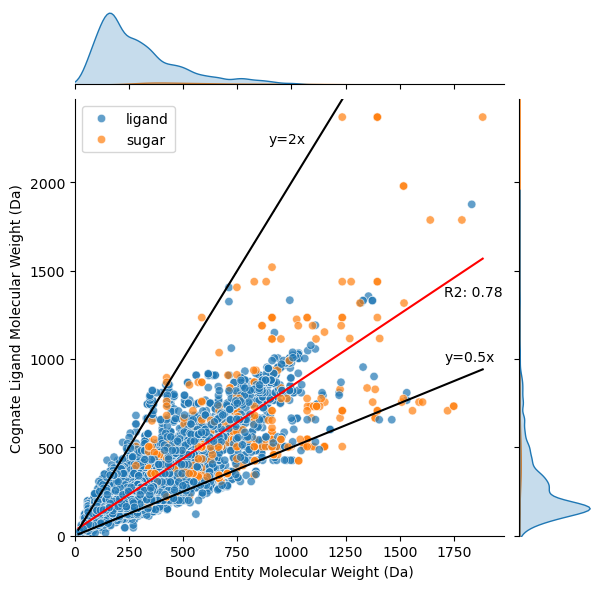

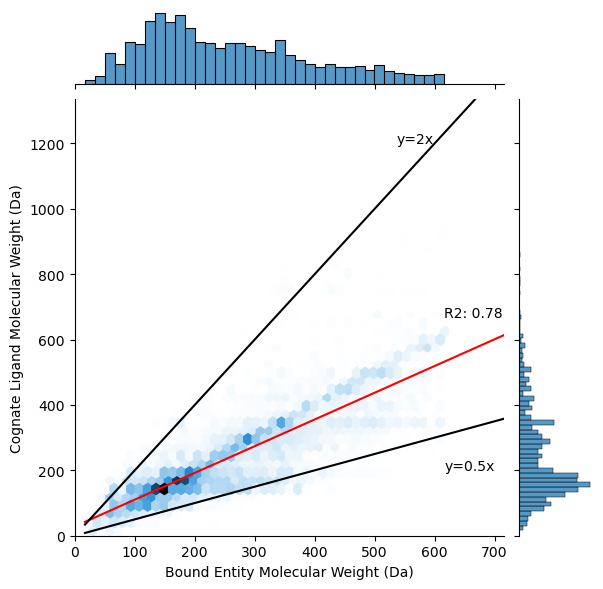

In [25]:
x_all = molecular_weight_query_result["pdb_mol_wt"]
y_all = molecular_weight_query_result["cognate_mol_wt"]
X_all = sm.add_constant(x_all) 
est_all = sm.OLS(y_all, X_all).fit()
p_all = est_all.params

#fig , ax = plt.subplots()
sns.jointplot(data = molecular_weight_query_result, kind = "scatter" , x = "pdb_mol_wt", y = "cognate_mol_wt", hue = "pdb_ligand_type", alpha = 0.4)
sns.lineplot(x= x_all, y = p_all.const + p_all.pdb_mol_wt * x_all, color = "red")
sns.lineplot(x= x_all, y = 2 * x_all, color = "black")
sns.lineplot(x= x_all, y = 0.5 * x_all, color = "black")
plt.xlim([0, molecular_weight_query_result["pdb_mol_wt"].max() + 100])
plt.ylim([0, molecular_weight_query_result["cognate_mol_wt"].max() + 100])
plt.text(0.86, 0.55, f'R2: {est_all.rsquared.round(2)}', transform=plt.gca().transAxes)
plt.text(0.86, 0.40, f'y=0.5x', transform=plt.gca().transAxes)
plt.text(0.45, 0.9, f'y=2x', transform=plt.gca().transAxes)
#plt.axhline(y=1650)
#plt.show()
plt.xlabel("Bound Entity Molecular Weight (Da)")
plt.ylabel("Cognate Ligand Molecular Weight (Da)")
plt.savefig(f"{analysis_output_path}/figures/molwt_plots/molwt_scatterplot_all.svg")


subset_molwt = molecular_weight_query_result.loc[(molecular_weight_query_result.pdb_mol_wt <= np.ceil(molecular_weight_query_result.pdb_mol_wt.quantile(0.90)))]
#do a zoomed inset hexplot of the lower part of the axis
sns.jointplot(data = subset_molwt, kind = "hex", x = "pdb_mol_wt", y = "cognate_mol_wt", )#hue = "pdb_ligand_type")
sns.lineplot(x= x_all, y = p_all.const + p_all.pdb_mol_wt * x_all, color = "red")
sns.lineplot(x= x_all, y = 2 * x_all, color = "black")
sns.lineplot(x= x_all, y = 0.5 * x_all, color = "black")
plt.xlim([0, subset_molwt["pdb_mol_wt"].max() + 100])
plt.ylim([0, subset_molwt["cognate_mol_wt"].max() + 100])
plt.text(0.86, 0.5, f'R2: {est_all.rsquared.round(2)}', transform=plt.gca().transAxes)
plt.text(0.86, 0.15, f'y=0.5x', transform=plt.gca().transAxes)
plt.text(0.75, 0.9, f'y=2x', transform=plt.gca().transAxes)

plt.xlabel("Bound Entity Molecular Weight (Da)")
plt.ylabel("Cognate Ligand Molecular Weight (Da)")
#plt.axhline(y=1650)
#plt.show()
plt.savefig(f"{analysis_output_path}/figures/molwt_plots/sub_molwt_hexbin_plot.svg")


#We see a lot of heterosckedacity in the plot, and a lot of this is due to the sugars at higher molecular weights. Investigating the relationship of just ligands.

In [33]:
mol1 = molecular_weight_query_result.loc[molecular_weight_query_result.cognate_mol_wt > 1400].pdb_ROMol.values[5]
mol2 = molecular_weight_query_result.loc[molecular_weight_query_result.cognate_mol_wt > 1400].cognate_ROMol.values[5]

# Define the SMARTS pattern
smarts = '[#6]-&!@[#8]-&!@[#6]1-&@[#8]-&@[#6](-&!@[#6]-&!@[#8]-&!@[#6]2-&@[#8]-&@[#6](-&!@[#6]-&!@[#8]-&!@[#6]3-&@[#8]-&@[#6](-&!@[#6]-&!@[#8])-&@[#6](-&@[#6](-&@[#6]-&@3-&!@[#8])-&!@[#8])-&!@[#8])-&@[#6](-&@[#6](-&@[#6]-&@2-&!@[#8])-&!@[#8])-&!@[#8])-&@[#6](-&@[#6](-&@[#6]-&@1-&!@[#8])-&!@[#8]-&!@[#6]1-&@[#8]-&@[#6](-&!@[#6]-&!@[#8])-&@[#6](-&@[#6](-&@[#6]-&@1-&!@[#8]-&!@[#6]1-&@[#8]-&@[#6](-&!@[#6]-&!@[#8])-&@[#6](-&@[#6](-&@[#6]-&@1-&!@[#7]-&!@[#6](-&!@[#6])=&!@[#8])-&!@[#8])-&!@[#8])-&!@[#8])-&!@[#8])-&!@[#8]'

# Create RDKit molecule object for the SMARTS pattern
pattern = Chem.MolFromSmarts(smarts)

# Find the substructure matches in the molecules
match1 = mol1.GetSubstructMatch(pattern)
match2 = mol2.GetSubstructMatch(pattern)

# Create highlight dictionaries
highlight1 = {atom_idx: (0.9, 0.1, 0.1) for atom_idx in match1}  # Red highlight
highlight2 = {atom_idx: (0.1, 0.9, 0.1) for atom_idx in match2}  # Green highlight

# Draw the molecules with highlights
drawer1 = Draw.MolDraw2DSVG(300, 300)
drawer1.drawOptions().highlightColor = (0.9, 0.1, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer1, mol1, highlightAtoms=match1)
drawer1.FinishDrawing()
svg1 = drawer1.GetDrawingText()

drawer2 = Draw.MolDraw2DSVG(300, 300)
drawer2.drawOptions().highlightColor = (0.1, 0.9, 0.1)
Draw.rdMolDraw2D.PrepareAndDrawMolecule(drawer2, mol2, highlightAtoms=match2)
drawer2.FinishDrawing()
svg2 = drawer2.GetDrawingText()

# Save SVGs to files
with open(f'{analysis_output_path}/figures/sugar_parity/3bvx_pdb_sugar.svg', 'w') as f:
    f.write(svg1)

with open(f'{analysis_output_path}/figures/sugar_parity/3bvx_cognate_sugar.svg', 'w') as f:
    f.write(svg2)

print("SVG files saved successfully.")

SVG files saved successfully.


In [10]:
if not os.path.exists(f"{analysis_output_path}/data/random_parity_scores_2k.pkl"):
    cognate_ligands_grouped =  cognate_ligands.groupby(["canonical_smiles", "uniqueID"]).agg({"entry": set}).reset_index()
    bound_entities["ec_list"] = bound_entities["ec_list"].str.join(",").str.split(",")
    all_random_parity_scores_list = []
    for x in range(0,5):
        random_parity_scores_matched = pd.DataFrame()
        to_match = 2000
        shuffle_state = 1 
        while to_match > 0:
            random_pdb_ligands_matched = bound_entities.sample(n=to_match, random_state = 10001)
            random_cognate_ligands_matched = cognate_ligands_grouped.sample(n=to_match, random_state = 10001)

            combined = pd.concat([random_pdb_ligands_matched[["ligand_entity_id", "descriptor", "ec_list"]].reset_index(drop = True), random_cognate_ligands_matched[["canonical_smiles", "uniqueID", "entry"]].rename(columns = {"uniqueID": "cognateUniqueID"}).reset_index(drop = True)], axis = 1)
            random_parity_scores_matched = pd.concat([random_parity_scores_matched, combined])
            random_parity_scores_matched['ec_match'] = random_parity_scores_matched.apply(lambda row: check_ec_lists(row), axis=1)
            random_parity_scores_matched = random_parity_scores_matched.loc[random_parity_scores_matched.ec_match != True]
            
            to_match -= len(random_parity_scores_matched)
            bound_entities = bound_entities.sample(n = len(bound_entities), random_state = shuffle_state)
            cognate_ligands_grouped = cognate_ligands_grouped.sample(n = len(cognate_ligands_grouped), random_state = shuffle_state)
            shuffle_state += 1
        
    
        random_parity_scores_matched["parityScore"] = random_parity_scores_matched.apply(lambda x: score_random_pairs(x), axis = 1)
        random_parity_scores_matched["quantile_95"] = random_parity_scores_matched.parityScore.quantile(0.95)
        random_parity_scores_matched["type"] = "Random"
        random_parity_scores_matched["rep"] = x
        all_random_parity_scores_list.append(random_parity_scores_matched)
    all_random_parity_scores = pd.concat(all_random_parity_scores_list)
    all_random_parity_scores.to_pickle(f"{analysis_output_path}/data/random_parity_scores_2k.pkl")
else:
    all_random_parity_scores = pd.read_pickle(f"{analysis_output_path}/data/random_parity_scores_2k.pkl")

In [21]:
print(f"""
The mean random parity score is {all_random_parity_scores.groupby("rep").agg({"quantile_95":"first"}).mean().values[0]}
The std random parity score is {all_random_parity_scores.groupby("rep").agg({"quantile_95":"first"}).std().values[0]}
""")


The mean random parity score is 0.28859962862288435
The std random parity score is 0.011402587559883322




Min Cogligs across databases at 0.4 PARITY: 1189
Max Cogligs across databases at 0.4 PARITY: 2710
Mean cogligs across databases at 0.4 PARITY: 2124.5
St. Dev cogligs across databases at 0.4 PARITY: 508.85



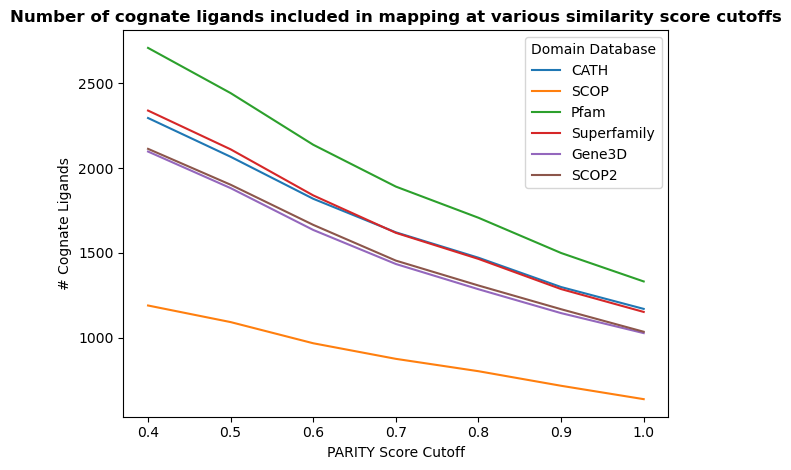

In [4]:
bound_entities_with_coglig = """
MATCH (c:cathDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "CATH" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:scopDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SCOP" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:pfamDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "Pfam" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:superfamilyDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "Superfamily" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:gene3dDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "Gene3D" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:scop2faDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SCOP2-FA" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:scop2sfDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SCOP2-SF" as type, $parity_score_cutoff as cutoff
"""


bound_entities_with_coglig_result_04 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.4)])
bound_entities_with_coglig_result_05 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.5)])
bound_entities_with_coglig_result_06 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.6)])
bound_entities_with_coglig_result_07 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.7)])
bound_entities_with_coglig_result_08 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.8)])
bound_entities_with_coglig_result_09 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.9)])
bound_entities_with_coglig_result_1 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=1.0)])

combined_be_with_coglig = pd.concat([bound_entities_with_coglig_result_04,bound_entities_with_coglig_result_05,bound_entities_with_coglig_result_06, bound_entities_with_coglig_result_07, bound_entities_with_coglig_result_08, bound_entities_with_coglig_result_09, bound_entities_with_coglig_result_1])
#remove the scop2-fa from here. it is only used for small number of situations and is just intended for ref not use
combined_be_with_coglig = combined_be_with_coglig.loc[combined_be_with_coglig.type != "SCOP2-FA"]
combined_be_with_coglig.loc[combined_be_with_coglig.type == "SCOP2-SF", "type"] = "SCOP2"

print(f"""
Min Cogligs across databases at 0.4 PARITY: {combined_be_with_coglig.loc[combined_be_with_coglig.cutoff == 0.4].num_bl_unique_ids.min()}
Max Cogligs across databases at 0.4 PARITY: {combined_be_with_coglig.loc[combined_be_with_coglig.cutoff == 0.4].num_bl_unique_ids.max()}
Mean cogligs across databases at 0.4 PARITY: {round(combined_be_with_coglig.loc[combined_be_with_coglig.cutoff == 0.4].num_bl_unique_ids.mean(), 2)}
St. Dev cogligs across databases at 0.4 PARITY: {round(combined_be_with_coglig.loc[combined_be_with_coglig.cutoff == 0.4].num_bl_unique_ids.std(), 2)}
""")

fig,ax = plt.subplots()

sns.lineplot(data = combined_be_with_coglig, x = "cutoff", y = "num_bl_unique_ids", hue = "type")

plt.title("Number of cognate ligands included in mapping at various similarity score cutoffs", fontweight="bold")
plt.xlabel("PARITY Score Cutoff")
plt.ylabel("# Cognate Ligands")
plt.legend(title = "Domain Database")
#plt.show()
plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/cognate_ligand_cutoff/cognate_ligand_cutoff.svg")